**NOTE** Currently this notebook runs with MlpMixer on GPUs and TPUs, but Vision
Transformers only run on GPUs. This is due to a temporary regression in the TPU
Node setup that is used for Colab and will be fixed soon.

See code at https://github.com/google-research/vision_transformer/

See papers at

- Vision Transformer: https://arxiv.org/abs/2010.11929
- MLP-Mixer: https://arxiv.org/abs/2105.01601
- How to train your ViT: https://arxiv.org/abs/2106.10270
- When Vision Transformers Outperform ResNets without Pretraining or Strong Data Augmentations: https://arxiv.org/abs/2106.01548

This Colab allows you to run the [JAX](https://jax.readthedocs.org) implementation of the Vision Transformer.

If you just want to load a pre-trained checkpoint from a large repository and
directly use it for inference, you probably want to go the other Colab

https://colab.sandbox.google.com/github/google-research/vision_transformer/blob/linen/vit_jax_augreg.ipynb

##### Copyright 2021 Google LLC.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<a href="https://colab.research.google.com/github/google-research/vision_transformer/blob/master/vit_jax.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Setup

Needs to be executed once in every VM.

The cell below downloads the code from Github and install necessary dependencies.

In [1]:
#@markdown Select whether you would like to store data in your personal drive.
#@markdown
#@markdown If you select **yes**, you will need to authorize Colab to access
#@markdown your personal drive
#@markdown
#@markdown If you select **no**, then any changes you make will diappear when
#@markdown this Colab's VM restarts after some time of inactivity...
use_gdrive = 'no'  #@param ["yes", "no"]

if use_gdrive == 'yes':
  from google.colab import drive
  drive.mount('/gdrive')
  root = '/gdrive/My Drive/vision_transformer_colab'
  import os
  if not os.path.isdir(root):
    os.mkdir(root)
  os.chdir(root)
  print(f'\nChanged CWD to "{root}"')
else:
  from IPython import display
  display.display(display.HTML(
      '<h1 style="color:red">CHANGES NOT PERSISTED</h1>'))

In [2]:
# Clone repository and pull latest changes.
![ -d vision_transformer ] || git clone --depth=1 https://github.com/google-research/vision_transformer
!cd vision_transformer && git pull

Already up to date.


In [3]:
!pip install -qr vision_transformer/vit_jax/requirements.txt

### Imports

In [4]:
# Shows all available pre-trained models.
!gsutil ls -lh gs://vit_models/imagenet*
!gsutil ls -lh gs://vit_models/sam
!gsutil ls -lh gs://mixer_models/*

gs://vit_models/imagenet21k+imagenet2012/:
377.57 MiB  2020-11-30T16:17:02Z  gs://vit_models/imagenet21k+imagenet2012/R50+ViT-B_16.npz
330.29 MiB  2020-10-29T17:05:52Z  gs://vit_models/imagenet21k+imagenet2012/ViT-B_16-224.npz
 331.4 MiB  2020-10-20T11:48:22Z  gs://vit_models/imagenet21k+imagenet2012/ViT-B_16.npz
336.89 MiB  2020-10-20T11:47:36Z  gs://vit_models/imagenet21k+imagenet2012/ViT-B_32.npz
334.78 MiB  2021-03-12T09:04:16Z  gs://vit_models/imagenet21k+imagenet2012/ViT-B_8.npz
  1.13 GiB  2020-10-29T17:08:31Z  gs://vit_models/imagenet21k+imagenet2012/ViT-L_16-224.npz
  1.14 GiB  2020-10-20T11:53:44Z  gs://vit_models/imagenet21k+imagenet2012/ViT-L_16.npz
  1.14 GiB  2020-10-20T11:50:56Z  gs://vit_models/imagenet21k+imagenet2012/ViT-L_32.npz

gs://vit_models/imagenet21k/:
450.23 MiB  2021-01-20T14:12:43Z  gs://vit_models/imagenet21k/R26+ViT-B_32.npz
439.85 MiB  2020-11-30T10:10:15Z  gs://vit_models/imagenet21k/R50+ViT-B_16.npz
  1.31 GiB  2021-01-20T14:11:54Z  gs://vit_models/ima

In [5]:
# Download a pre-trained model.

# Note: you can really choose any of the above, but this Colab has been tested
# with the models of below selection...
model_name = 'Mixer-B_16'  #@param ["ViT-B_32", "Mixer-B_16"]

if model_name.startswith('ViT'):
  ![ -e "$model_name".npz ] || gsutil cp gs://vit_models/imagenet21k/"$model_name".npz .
if model_name.startswith('Mixer'):
  ![ -e "$model_name".npz ] || gsutil cp gs://mixer_models/sam/"$model_name".npz .

import os
assert os.path.exists(f'{model_name}.npz')

In [4]:
# Google Colab "TPU" runtimes are configured in "2VM mode", meaning that JAX
# cannot see the TPUs because they're not directly attached. Instead we need to
# setup JAX to communicate with a second machine that has the TPUs attached.
import os
if 'google.colab' in str(get_ipython()) and 'COLAB_TPU_ADDR' in os.environ:
  import jax
  import jax.tools.colab_tpu
  jax.tools.colab_tpu.setup_tpu()
  print('Connected to TPU.')
else:
  print('No TPU detected. Can be changed under "Runtime/Change runtime type".')

Connected to TPU.


In [5]:
from absl import logging
import flax
import jax
from matplotlib import pyplot as plt
import numpy as np
import tqdm

logging.set_verbosity(logging.INFO)

# Shows the number of available devices.
# In a CPU/GPU runtime this will be a single device.
# In a TPU runtime this will be 8 cores.
jax.local_devices()

INFO:absl:Unable to initialize backend 'gpu': FAILED_PRECONDITION: No visible GPU devices.
INFO:absl:Unable to initialize backend 'tpu': INVALID_ARGUMENT: TpuPlatform is not available.


[TpuDevice(id=0, process_index=0, coords=(0,0,0), core_on_chip=0),
 TpuDevice(id=1, process_index=0, coords=(0,0,0), core_on_chip=1),
 TpuDevice(id=2, process_index=0, coords=(1,0,0), core_on_chip=0),
 TpuDevice(id=3, process_index=0, coords=(1,0,0), core_on_chip=1),
 TpuDevice(id=4, process_index=0, coords=(0,1,0), core_on_chip=0),
 TpuDevice(id=5, process_index=0, coords=(0,1,0), core_on_chip=1),
 TpuDevice(id=6, process_index=0, coords=(1,1,0), core_on_chip=0),
 TpuDevice(id=7, process_index=0, coords=(1,1,0), core_on_chip=1)]

In [6]:
# Import files from repository.
# Updating the files in the editor on the right will immediately update the
# modules by re-importing them.

import sys
if './vision_transformer' not in sys.path:
  sys.path.append('./vision_transformer')

%load_ext autoreload
%autoreload 2

from vit_jax import checkpoint
from vit_jax import input_pipeline
from vit_jax import utils
from vit_jax import models
from vit_jax import momentum_clip
from vit_jax import train
from vit_jax.configs import common as common_config
from vit_jax.configs import models as models_config

In [7]:
# Helper functions for images.

labelnames = dict(
  # https://www.cs.toronto.edu/~kriz/cifar.html
  cifar10=('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'),
  # https://www.cs.toronto.edu/~kriz/cifar.html
  cifar100=('apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'computer_keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm')
)
def make_label_getter(dataset):
  """Returns a function converting label indices to names."""
  def getter(label):
    if dataset in labelnames:
      return labelnames[dataset][label]
    return f'label={label}'
  return getter

def show_img(img, ax=None, title=None):
  """Shows a single image."""
  if ax is None:
    ax = plt.gca()
  ax.imshow(img[...])
  ax.set_xticks([])
  ax.set_yticks([])
  if title:
    ax.set_title(title)

def show_img_grid(imgs, titles):
  """Shows a grid of images."""
  n = int(np.ceil(len(imgs)**.5))
  _, axs = plt.subplots(n, n, figsize=(3 * n, 3 * n))
  for i, (img, title) in enumerate(zip(imgs, titles)):
    img = (img + 1) / 2  # Denormalize
    show_img(img, axs[i // n][i % n], title)

### Load dataset

In [8]:
dataset = 'cifar10'
batch_size = 512
config = common_config.with_dataset(common_config.get_config(), dataset)
num_classes = input_pipeline.get_dataset_info(dataset, 'train')['num_classes']
config.batch = batch_size
config.pp.crop = 224

INFO:absl:Load dataset info from /root/tensorflow_datasets/cifar10/3.0.2


In [9]:
# For details about setting up datasets, see input_pipeline.py on the right.
ds_train = input_pipeline.get_data_from_tfds(config=config, mode='train')
ds_test = input_pipeline.get_data_from_tfds(config=config, mode='test')

del config  # Only needed to instantiate datasets.

INFO:absl:Load dataset info from /root/tensorflow_datasets/cifar10/3.0.2
INFO:absl:Reusing dataset cifar10 (/root/tensorflow_datasets/cifar10/3.0.2)
INFO:absl:Constructing tf.data.Dataset for split train[:98%], from /root/tensorflow_datasets/cifar10/3.0.2
INFO:absl:Load dataset info from /root/tensorflow_datasets/cifar10/3.0.2
INFO:absl:Load dataset info from /root/tensorflow_datasets/cifar10/3.0.2
INFO:absl:Reusing dataset cifar10 (/root/tensorflow_datasets/cifar10/3.0.2)
INFO:absl:Constructing tf.data.Dataset for split test, from /root/tensorflow_datasets/cifar10/3.0.2
INFO:absl:Load dataset info from /root/tensorflow_datasets/cifar10/3.0.2


In [10]:
# Fetch a batch of test images for illustration purposes.
batch = next(iter(ds_test.as_numpy_iterator()))
# Note the shape : [num_local_devices, local_batch_size, h, w, c]
batch['image'].shape

(8, 64, 224, 224, 3)

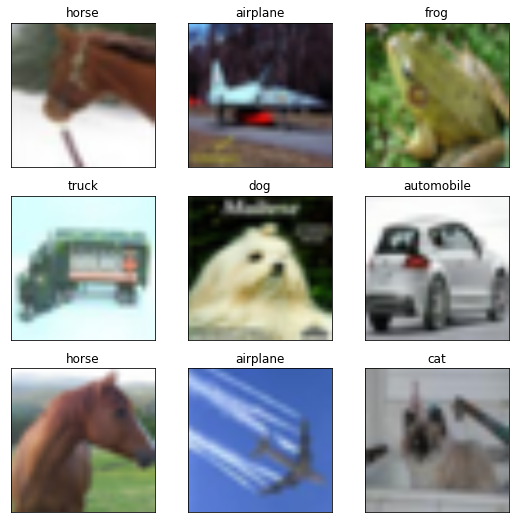

In [11]:
# Show some imags with their labels.
images, labels = batch['image'][0][:9], batch['label'][0][:9]
titles = map(make_label_getter(dataset), labels.argmax(axis=1))
show_img_grid(images, titles)

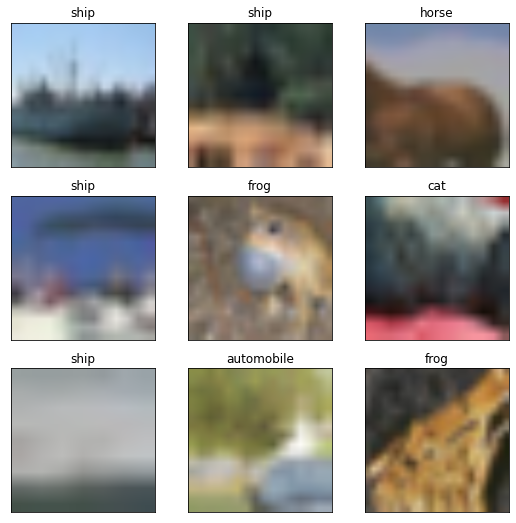

In [12]:
# Same as above, but with train images.
# Note how images are cropped/scaled differently.
# Check out input_pipeline.get_data() in the editor at your right to see how the
# images are preprocessed differently.
batch = next(iter(ds_train.as_numpy_iterator()))
images, labels = batch['image'][0][:9], batch['label'][0][:9]
titles = map(make_label_getter(dataset), labels.argmax(axis=1))
show_img_grid(images, titles)

### Load pre-trained

In [35]:
model_config = models_config.MODEL_CONFIGS[model_name]
model_config

channels_mlp_dim: 3072
hidden_dim: 768
name: Mixer-B_16
num_blocks: 12
patches:
  size: !!python/tuple
  - 16
  - 16
tokens_mlp_dim: 384

In [36]:
# Load model definition & initialize random parameters.
# This also compiles the model to XLA (takes some minutes the first time).
if model_name.startswith('Mixer'):
  model = models.MlpMixer(num_classes=num_classes, **model_config)
else:
  model = models.VisionTransformer(num_classes=num_classes, **model_config)
variables = jax.jit(lambda: model.init(
    jax.random.PRNGKey(0),
    # Discard the "num_local_devices" dimension of the batch for initialization.
    batch['image'][0, :1],
    train=False,
), backend='cpu')()

In [48]:
# Load and convert pretrained checkpoint.
# This involves loading the actual pre-trained model results, but then also also
# modifying the parameters a bit, e.g. changing the final layers, and resizing
# the positional embeddings.
# For details, refer to the code and to the methods of the paper.
params = checkpoint.load_pretrained(
    pretrained_path=f'{model_name}.npz',
    init_params=variables['params'],
    model_config=model_config,
)

### Evaluate

In [49]:
# So far, all our data is in the host memory. Let's now replicate the arrays
# into the devices.
# This will make every array in the pytree params become a ShardedDeviceArray
# that has the same data replicated across all local devices.
# For TPU it replicates the params in every core.
# For a single GPU this simply moves the data onto the device.
# For CPU it simply creates a copy.
params_repl = flax.jax_utils.replicate(params)
print('params.cls:', type(params['head']['bias']).__name__,
      params['head']['bias'].shape)
print('params_repl.cls:', type(params_repl['head']['bias']).__name__,
      params_repl['head']['bias'].shape)

params.cls: DeviceArray (10,)
params_repl.cls: _ShardedDeviceArray (8, 10)


In [39]:
# Then map the call to our model's forward pass onto all available devices.
vit_apply_repl = jax.pmap(lambda params, inputs: model.apply(
    dict(params=params), inputs, train=False))

In [13]:
def get_accuracy(params_repl):
  """Returns accuracy evaluated on the test set."""
  good = total = 0
  steps = input_pipeline.get_dataset_info(dataset, 'test')['num_examples'] // batch_size
  for _, batch in zip(tqdm.trange(steps), ds_test.as_numpy_iterator()):
    predicted = vit_apply_repl(params_repl, batch['image'])
    is_same = predicted.argmax(axis=-1) == batch['label'].argmax(axis=-1)
    good += is_same.sum()
    total += len(is_same.flatten())
  return good / total

In [41]:
# Random performance without fine-tuning.
get_accuracy(params_repl)

INFO:absl:Load dataset info from /root/tensorflow_datasets/cifar10/3.0.2
100%|██████████| 19/19 [01:10<00:00,  3.70s/it]


DeviceArray(0.10063734, dtype=float32)

### Fine-tune

In [14]:
# 100 Steps take approximately 15 minutes in the TPU runtime.
total_steps = 30
warmup_steps = 3
decay_type = 'cosine'
grad_norm_clip = 1
# This controls in how many forward passes the batch is split. 8 works well with
# a TPU runtime that has 8 devices. 64 should work on a GPU. You can of course
# also adjust the batch_size above, but that would require you to adjust the
# learning rate accordingly.
accum_steps = 8
base_lr = 0.03

In [50]:
# Check out train.make_update_fn in the editor on the right side for details.
lr_fn = utils.create_learning_rate_schedule(total_steps, base_lr, decay_type, warmup_steps)
update_fn_repl = train.make_update_fn(
    apply_fn=model.apply, accum_steps=accum_steps, lr_fn=lr_fn)
# We use a momentum optimizer that uses half precision for state to save
# memory. It als implements the gradient clipping.
opt = momentum_clip.Optimizer(grad_norm_clip=grad_norm_clip).create(params)
opt_repl = flax.jax_utils.replicate(opt)

In [51]:
# Initialize PRNGs for dropout.
update_rng_repl = flax.jax_utils.replicate(jax.random.PRNGKey(0))

100%|██████████| 100/100 [07:41<00:00,  4.62s/it]


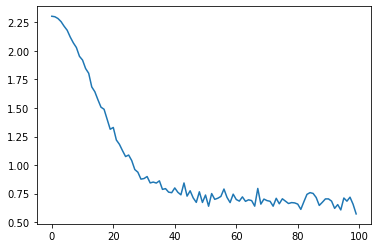

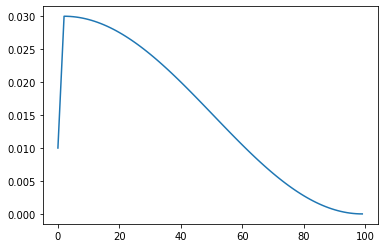

In [52]:
losses = []
lrs = []
# Completes in ~20 min on the TPU runtime.
for step, batch in zip(
    tqdm.trange(1, total_steps + 1),
    ds_train.as_numpy_iterator(),
):

  opt_repl, loss_repl, update_rng_repl = update_fn_repl(
      opt_repl, flax.jax_utils.replicate(step), batch, update_rng_repl)
  losses.append(loss_repl[0])
  lrs.append(lr_fn(step))

plt.plot(losses)
plt.figure()
plt.plot(lrs)

In [53]:
# Should be ~96.7% for Mixer-B/16 or 97.7% for ViT-B/32 on CIFAR10 (both @224)
get_accuracy(opt_repl.target)

INFO:absl:Load dataset info from /root/tensorflow_datasets/cifar10/3.0.2
100%|██████████| 19/19 [00:56<00:00,  2.97s/it]


DeviceArray(0.9379112, dtype=float32)

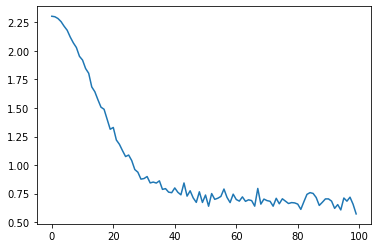

In [54]:
sam_losses = losses

In [55]:
!rm Mixer-B_16.npz

In [56]:
# Download a pre-trained model.

# Note: you can really choose any of the above, but this Colab has been tested
# with the models of below selection...
model_name = 'Mixer-B_16'  #@param ["ViT-B_32", "Mixer-B_16"]

if model_name.startswith('ViT'):
  ![ -e "$model_name".npz ] || gsutil cp gs://vit_models/imagenet1k/"$model_name".npz .
if model_name.startswith('Mixer'):
  ![ -e "$model_name".npz ] || gsutil cp gs://mixer_models/imagenet1k/"$model_name".npz .

import os
assert os.path.exists(f'{model_name}.npz')

Copying gs://mixer_models/imagenet1k/Mixer-B_16.npz...
/ [1 files][228.5 MiB/228.5 MiB]                                                
Operation completed over 1 objects/228.5 MiB.                                    


params.cls: DeviceArray (10,)
params_repl.cls: _ShardedDeviceArray (8, 10)


100%|██████████| 30/30 [04:00<00:00,  8.03s/it]


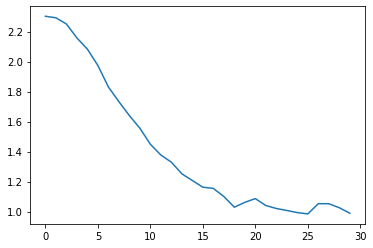

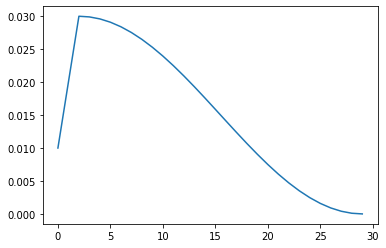

In [58]:
# Load model definition & initialize random parameters.
# This also compiles the model to XLA (takes some minutes the first time).
if model_name.startswith('Mixer'):
  model = models.MlpMixer(num_classes=num_classes, **model_config)
else:
  model = models.VisionTransformer(num_classes=num_classes, **model_config)
variables = jax.jit(lambda: model.init(
    jax.random.PRNGKey(0),
    # Discard the "num_local_devices" dimension of the batch for initialization.
    batch['image'][0, :1],
    train=False,
), backend='cpu')()

# Load and convert pretrained checkpoint.
# This involves loading the actual pre-trained model results, but then also also
# modifying the parameters a bit, e.g. changing the final layers, and resizing
# the positional embeddings.
# For details, refer to the code and to the methods of the paper.
params = checkpoint.load_pretrained(
    pretrained_path=f'{model_name}.npz',
    init_params=variables['params'],
    model_config=model_config,
)

# So far, all our data is in the host memory. Let's now replicate the arrays
# into the devices.
# This will make every array in the pytree params become a ShardedDeviceArray
# that has the same data replicated across all local devices.
# For TPU it replicates the params in every core.
# For a single GPU this simply moves the data onto the device.
# For CPU it simply creates a copy.
params_repl = flax.jax_utils.replicate(params)
print('params.cls:', type(params['head']['bias']).__name__,
      params['head']['bias'].shape)
print('params_repl.cls:', type(params_repl['head']['bias']).__name__,
      params_repl['head']['bias'].shape)

# Then map the call to our model's forward pass onto all available devices.
vit_apply_repl = jax.pmap(lambda params, inputs: model.apply(
    dict(params=params), inputs, train=False))

# Check out train.make_update_fn in the editor on the right side for details.
lr_fn = utils.create_learning_rate_schedule(total_steps, base_lr, decay_type, warmup_steps)
update_fn_repl = train.make_update_fn(
    apply_fn=model.apply, accum_steps=accum_steps, lr_fn=lr_fn)
# We use a momentum optimizer that uses half precision for state to save
# memory. It als implements the gradient clipping.
opt = momentum_clip.Optimizer(grad_norm_clip=grad_norm_clip).create(params)
opt_repl = flax.jax_utils.replicate(opt)

# Initialize PRNGs for dropout.
update_rng_repl = flax.jax_utils.replicate(jax.random.PRNGKey(0))

losses = []
lrs = []
# Completes in ~20 min on the TPU runtime.
for step, batch in zip(
    tqdm.trange(1, total_steps + 1),
    ds_train.as_numpy_iterator(),
):

  opt_repl, loss_repl, update_rng_repl = update_fn_repl(
      opt_repl, flax.jax_utils.replicate(step), batch, update_rng_repl)
  losses.append(loss_repl[0])
  lrs.append(lr_fn(step))

plt.plot(losses)
plt.figure()
plt.plot(lrs)

In [59]:
get_accuracy(opt_repl.target)

INFO:absl:Load dataset info from /root/tensorflow_datasets/cifar10/3.0.2
100%|██████████| 19/19 [01:07<00:00,  3.56s/it]


DeviceArray(0.86369246, dtype=float32)

In [60]:
mlp_loss = losses

In [61]:
!rm Mixer-B_16.npz

In [62]:
# Download a pre-trained model.

# Note: you can really choose any of the above, but this Colab has been tested
# with the models of below selection...
model_name = 'Mixer-B_16'

if model_name.startswith('ViT'):
  ![ -e "$model_name".npz ] || gsutil cp gs://vit_models/sam/"$model_name".npz .
if model_name.startswith('Mixer'):
  ![ -e "$model_name".npz ] || gsutil cp gs://mixer_models/sam/"$model_name".npz .

import os
assert os.path.exists(f'{model_name}.npz')

Copying gs://mixer_models/sam/Mixer-B_16.npz...
/ [1 files][228.5 MiB/228.5 MiB]                                                
Operation completed over 1 objects/228.5 MiB.                                    


In [18]:
# Load and convert pretrained checkpoint.
# This involves loading the actual pre-trained model results, but then also also
# modifying the parameters a bit, e.g. changing the final layers, and resizing
# the positional embeddings.
# For details, refer to the code and to the methods of the paper.
params = checkpoint.load_pretrained(
    pretrained_path=f'{model_name}.npz',
    init_params=variables['params'],
    model_config=model_config,
)

# So far, all our data is in the host memory. Let's now replicate the arrays
# into the devices.
# This will make every array in the pytree params become a ShardedDeviceArray
# that has the same data replicated across all local devices.
# For TPU it replicates the params in every core.
# For a single GPU this simply moves the data onto the device.
# For CPU it simply creates a copy.
params_repl = flax.jax_utils.replicate(params)
print('params.cls:', type(params['head']['bias']).__name__,
      params['head']['bias'].shape)
print('params_repl.cls:', type(params_repl['head']['bias']).__name__,
      params_repl['head']['bias'].shape)

# Then map the call to our model's forward pass onto all available devices.
vit_apply_repl = jax.pmap(lambda params, inputs: model.apply(
    dict(params=params), inputs, train=False))

# Check out train.make_update_fn in the editor on the right side for details.
lr_fn = utils.create_learning_rate_schedule(total_steps, base_lr, decay_type, warmup_steps)
update_fn_repl = train.make_update_fn(
    apply_fn=model.apply, accum_steps=accum_steps, lr_fn=lr_fn)
# We use a momentum optimizer that uses half precision for state to save
# memory. It als implements the gradient clipping.
opt = momentum_clip.Optimizer(grad_norm_clip=grad_norm_clip).create(params)
opt_repl = flax.jax_utils.replicate(opt)

# Initialize PRNGs for dropout.
update_rng_repl = flax.jax_utils.replicate(jax.random.PRNGKey(0))

losses = []
lrs = []
# Completes in ~20 min on the TPU runtime.
for step, batch in zip(
    tqdm.trange(1, total_steps + 1),
    ds_train.as_numpy_iterator(),
):

  opt_repl, loss_repl, update_rng_repl = update_fn_repl(
      opt_repl, flax.jax_utils.replicate(step), batch, update_rng_repl)
  losses.append(loss_repl[0])
  lrs.append(lr_fn(step))

plt.plot(losses)
plt.figure()
plt.plot(lrs)

INFO:absl:Inspect extra keys:
{'pre_logits/kernel', 'pre_logits/bias'}
INFO:absl:load_pretrained: drop-head variant


params.cls: DeviceArray (10,)
params_repl.cls: _ShardedDeviceArray (8, 10)


  0%|          | 0/30 [01:18<?, ?it/s]


KeyboardInterrupt: ignored

In [64]:
get_accuracy(opt_repl.target)

INFO:absl:Load dataset info from /root/tensorflow_datasets/cifar10/3.0.2
100%|██████████| 19/19 [01:07<00:00,  3.57s/it]


DeviceArray(0.8203125, dtype=float32)

In [65]:
mlpsam_loss = losses

In [66]:
!rm Mixer-B_16.npz

In [70]:
# Download a pre-trained model.

# Note: you can really choose any of the above, but this Colab has been tested
# with the models of below selection...
model_name = 'Mixer-B_16'

if model_name.startswith('ViT'):
  ![ -e "$model_name".npz ] || gsutil cp gs://vit_models/imagenet21k/"$model_name".npz .
if model_name.startswith('Mixer'):
  ![ -e "$model_name".npz ] || gsutil cp gs://mixer_models/imagenet21k/"$model_name".npz .

import os
assert os.path.exists(f'{model_name}.npz')

Copying gs://mixer_models/imagenet21k/Mixer-B_16.npz...
\ [1 files][289.6 MiB/289.6 MiB]                                                
Operation completed over 1 objects/289.6 MiB.                                    


params.cls: DeviceArray (10,)
params_repl.cls: _ShardedDeviceArray (8, 10)


100%|██████████| 30/30 [03:48<00:00,  7.63s/it]


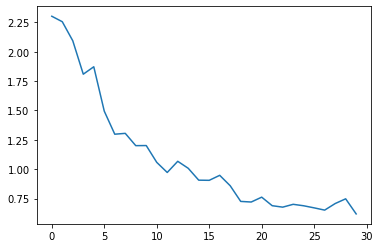

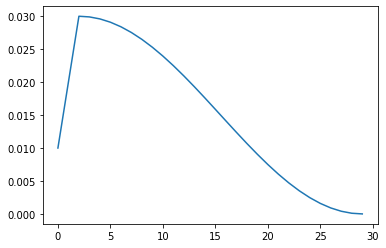

In [71]:
# Load model definition & initialize random parameters.
# This also compiles the model to XLA (takes some minutes the first time).
if model_name.startswith('Mixer'):
  model = models.MlpMixer(num_classes=num_classes, **model_config)
else:
  model = models.VisionTransformer(num_classes=num_classes, **model_config)
variables = jax.jit(lambda: model.init(
    jax.random.PRNGKey(0),
    # Discard the "num_local_devices" dimension of the batch for initialization.
    batch['image'][0, :1],
    train=False,
), backend='cpu')()

# Load and convert pretrained checkpoint.
# This involves loading the actual pre-trained model results, but then also also
# modifying the parameters a bit, e.g. changing the final layers, and resizing
# the positional embeddings.
# For details, refer to the code and to the methods of the paper.
params = checkpoint.load_pretrained(
    pretrained_path=f'{model_name}.npz',
    init_params=variables['params'],
    model_config=model_config,
)

# So far, all our data is in the host memory. Let's now replicate the arrays
# into the devices.
# This will make every array in the pytree params become a ShardedDeviceArray
# that has the same data replicated across all local devices.
# For TPU it replicates the params in every core.
# For a single GPU this simply moves the data onto the device.
# For CPU it simply creates a copy.
params_repl = flax.jax_utils.replicate(params)
print('params.cls:', type(params['head']['bias']).__name__,
      params['head']['bias'].shape)
print('params_repl.cls:', type(params_repl['head']['bias']).__name__,
      params_repl['head']['bias'].shape)

# Then map the call to our model's forward pass onto all available devices.
vit_apply_repl = jax.pmap(lambda params, inputs: model.apply(
    dict(params=params), inputs, train=False))

# Check out train.make_update_fn in the editor on the right side for details.
lr_fn = utils.create_learning_rate_schedule(total_steps, base_lr, decay_type, warmup_steps)
update_fn_repl = train.make_update_fn(
    apply_fn=model.apply, accum_steps=accum_steps, lr_fn=lr_fn)
# We use a momentum optimizer that uses half precision for state to save
# memory. It als implements the gradient clipping.
opt = momentum_clip.Optimizer(grad_norm_clip=grad_norm_clip).create(params)
opt_repl = flax.jax_utils.replicate(opt)

# Initialize PRNGs for dropout.
update_rng_repl = flax.jax_utils.replicate(jax.random.PRNGKey(0))

losses = []
lrs = []
# Completes in ~20 min on the TPU runtime.
for step, batch in zip(
    tqdm.trange(1, total_steps + 1),
    ds_train.as_numpy_iterator(),
):

  opt_repl, loss_repl, update_rng_repl = update_fn_repl(
      opt_repl, flax.jax_utils.replicate(step), batch, update_rng_repl)
  losses.append(loss_repl[0])
  lrs.append(lr_fn(step))

plt.plot(losses)
plt.figure()
plt.plot(lrs)

In [72]:
import time
start_time = time.time()
print(get_accuracy(opt_repl.target))
print('consumed', time.time() - start_time)

INFO:absl:Load dataset info from /root/tensorflow_datasets/cifar10/3.0.2
100%|██████████| 19/19 [01:07<00:00,  3.55s/it]


0.9397615
consumed 81.99165987968445


In [73]:
mlp21_loss = losses

In [15]:
# Download a pre-trained model.

# Note: you can really choose any of the above, but this Colab has been tested
# with the models of below selection...
model_name = 'ViT-B_32'

if model_name.startswith('ViT'):
  ![ -e "$model_name".npz ] || gsutil cp gs://vit_models/imagenet21k/"$model_name".npz .
if model_name.startswith('Mixer'):
  ![ -e "$model_name".npz ] || gsutil cp gs://mixer_models/imagenet21k/"$model_name".npz .

import os
assert os.path.exists(f'{model_name}.npz')

Copying gs://vit_models/imagenet21k/ViT-B_32.npz...
| [1 files][400.0 MiB/400.0 MiB]                                                
Operation completed over 1 objects/400.0 MiB.                                    


INFO:absl:Inspect extra keys:
{'pre_logits/bias', 'pre_logits/kernel'}
INFO:absl:load_pretrained: drop-head variant


params.cls: DeviceArray (10,)
params_repl.cls: _ShardedDeviceArray (8, 10)


100%|██████████| 30/30 [04:32<00:00,  9.08s/it]


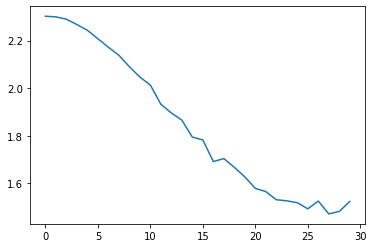

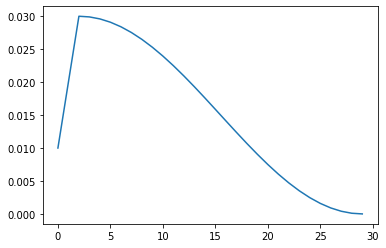

In [16]:
model_config = models_config.MODEL_CONFIGS[model_name]
model_config

# Load model definition & initialize random parameters.
# This also compiles the model to XLA (takes some minutes the first time).
if model_name.startswith('Mixer'):
  model = models.MlpMixer(num_classes=num_classes, **model_config)
else:
  model = models.VisionTransformer(num_classes=num_classes, **model_config)
variables = jax.jit(lambda: model.init(
    jax.random.PRNGKey(0),
    # Discard the "num_local_devices" dimension of the batch for initialization.
    batch['image'][0, :1],
    train=False,
), backend='cpu')()

# Load and convert pretrained checkpoint.
# This involves loading the actual pre-trained model results, but then also also
# modifying the parameters a bit, e.g. changing the final layers, and resizing
# the positional embeddings.
# For details, refer to the code and to the methods of the paper.
params = checkpoint.load_pretrained(
    pretrained_path=f'{model_name}.npz',
    init_params=variables['params'],
    model_config=model_config,
)

# So far, all our data is in the host memory. Let's now replicate the arrays
# into the devices.
# This will make every array in the pytree params become a ShardedDeviceArray
# that has the same data replicated across all local devices.
# For TPU it replicates the params in every core.
# For a single GPU this simply moves the data onto the device.
# For CPU it simply creates a copy.
params_repl = flax.jax_utils.replicate(params)
print('params.cls:', type(params['head']['bias']).__name__,
      params['head']['bias'].shape)
print('params_repl.cls:', type(params_repl['head']['bias']).__name__,
      params_repl['head']['bias'].shape)

# Then map the call to our model's forward pass onto all available devices.
vit_apply_repl = jax.pmap(lambda params, inputs: model.apply(
    dict(params=params), inputs, train=False))

# Check out train.make_update_fn in the editor on the right side for details.
lr_fn = utils.create_learning_rate_schedule(total_steps, base_lr, decay_type, warmup_steps)
update_fn_repl = train.make_update_fn(
    apply_fn=model.apply, accum_steps=accum_steps, lr_fn=lr_fn)
# We use a momentum optimizer that uses half precision for state to save
# memory. It als implements the gradient clipping.
opt = momentum_clip.Optimizer(grad_norm_clip=grad_norm_clip).create(params)
opt_repl = flax.jax_utils.replicate(opt)

# Initialize PRNGs for dropout.
update_rng_repl = flax.jax_utils.replicate(jax.random.PRNGKey(0))

losses = []
lrs = []
# Completes in ~20 min on the TPU runtime.
for step, batch in zip(
    tqdm.trange(1, total_steps + 1),
    ds_train.as_numpy_iterator(),
):

  opt_repl, loss_repl, update_rng_repl = update_fn_repl(
      opt_repl, flax.jax_utils.replicate(step), batch, update_rng_repl)
  losses.append(loss_repl[0])
  lrs.append(lr_fn(step))

plt.plot(losses)
plt.figure()
plt.plot(lrs)

In [17]:
import time
start_time = time.time()
print(get_accuracy(opt_repl.target))
print('consumed', time.time() - start_time)

INFO:absl:Load dataset info from /root/tensorflow_datasets/cifar10/3.0.2
100%|██████████| 19/19 [01:07<00:00,  3.53s/it]

0.9529194
consumed 67.2227668762207


In [19]:
vit_loss = losses

ViT-B_32 speed: train 272 sec
Mixer-B_16 speed: train 228 sec


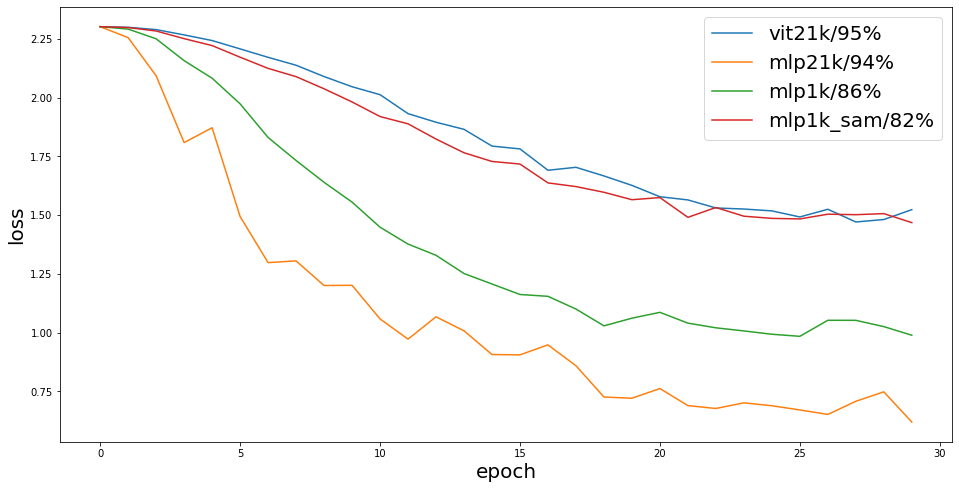

In [39]:
print('ViT-B_32 speed: train 272 sec')
print('Mixer-B_16 speed: train 228 sec')
plt.figure(figsize=(16, 8))
plt.plot(vit_loss, label='vit21k/95%')
plt.plot(mlp21_loss, label='mlp21k/94%')
plt.plot(mlp_loss, label='mlp1k/86%')
plt.plot(mlpsam_loss, label='mlp1k_sam/82%')
plt.legend(prop={'size': 20})
plt.xlabel('epoch', size=20)
plt.ylabel('loss', size=20)
plt.show()

In [ ]:
# тренируем сеть самостоятельно

In [ ]:
import torch
import numpy as np

In [ ]:
!wget --quiet --show-progress "https://download.pytorch.org/tutorial/hymenoptera_data.zip"
!unzip -q ./hymenoptera_data.zip

In [ ]:
%matplotlib inline

import time
import os

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision

from torchvision import datasets, models, transforms
from torch.optim import lr_scheduler


data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=64,
                                             shuffle=True)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

use_gpu = torch.cuda.is_available()
plt.ion()

In [ ]:
from tqdm.auto import tqdm
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in tqdm(dataloaders[phase]):
                # get the inputs
                inputs, labels = data

                if use_gpu:
                    inputs = inputs.cuda()
                    labels = labels.cuda()

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.item()
                running_corrects += torch.sum(preds == labels).type(torch.float)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()
        
        time_elapsed = time.time() - since
        print('Elapsed {:.0f}m {:.0f}s\n'.format(time_elapsed // 60, time_elapsed % 60))

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
!git clone https://github.com/rishikksh20/MLP-Mixer-pytorch

In [ ]:
!pip install einops

In [ ]:
from mlpmixer import MLPMixer


In [ ]:
model = torchvision.models.resnet18(pretrained=False)
parameters = sum([np.prod(p.size()) for p in model.parameters()])
print('Trainable Parameters: %d' % parameters)

# TODO: выберите, какие параметры дообучать. Результат получается лучше если дообучать всё или только последний слой? Почему?

params_to_train = list(model.parameters())

# use GPU if you have it
if use_gpu:
    model = model.cuda()

# loss
criterion = nn.CrossEntropyLoss()

# Create optimizer on the selected parameters
optimizer = optim.SGD(params_to_train, lr=0.01)

# Decay LR by a factor of 0.1 every 7 epochs
scheduler = lr_scheduler.StepLR(optimizer, 3, 0.3)

model = train_model(
    model, criterion, optimizer, scheduler, num_epochs=20)

Trainable Parameters: 11689512
Epoch 0/19
----------


  0%|          | 0/4 [00:00<?, ?it/s]

train Loss: 0.0747 Acc: 0.3648


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.0953 Acc: 0.6275
Elapsed 0m 6s

Epoch 1/19
----------


  0%|          | 0/4 [00:00<?, ?it/s]

train Loss: 0.0180 Acc: 0.5738


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.0635 Acc: 0.6209
Elapsed 0m 11s

Epoch 2/19
----------


  0%|          | 0/4 [00:00<?, ?it/s]

train Loss: 0.0130 Acc: 0.6230


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.0425 Acc: 0.5359
Elapsed 0m 17s

Epoch 3/19
----------


  0%|          | 0/4 [00:00<?, ?it/s]

train Loss: 0.0125 Acc: 0.6066


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.0288 Acc: 0.5556
Elapsed 0m 22s

Epoch 4/19
----------


  0%|          | 0/4 [00:00<?, ?it/s]

train Loss: 0.0120 Acc: 0.6230


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.0215 Acc: 0.6209
Elapsed 0m 28s

Epoch 5/19
----------


  0%|          | 0/4 [00:00<?, ?it/s]

train Loss: 0.0115 Acc: 0.6557


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.0179 Acc: 0.6275
Elapsed 0m 33s

Epoch 6/19
----------


  0%|          | 0/4 [00:00<?, ?it/s]

train Loss: 0.0114 Acc: 0.6762


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.0165 Acc: 0.6275
Elapsed 0m 39s

Epoch 7/19
----------


  0%|          | 0/4 [00:00<?, ?it/s]

train Loss: 0.0114 Acc: 0.6762


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.0150 Acc: 0.6340
Elapsed 0m 44s

Epoch 8/19
----------


  0%|          | 0/4 [00:00<?, ?it/s]

train Loss: 0.0112 Acc: 0.6475


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.0149 Acc: 0.6536
Elapsed 0m 50s

Epoch 9/19
----------


  0%|          | 0/4 [00:00<?, ?it/s]

train Loss: 0.0114 Acc: 0.6598


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.0143 Acc: 0.6471
Elapsed 0m 55s

Epoch 10/19
----------


  0%|          | 0/4 [00:00<?, ?it/s]

train Loss: 0.0112 Acc: 0.6885


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.0143 Acc: 0.6471
Elapsed 1m 1s

Epoch 11/19
----------


  0%|          | 0/4 [00:00<?, ?it/s]

train Loss: 0.0112 Acc: 0.6598


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.0143 Acc: 0.6471
Elapsed 1m 6s

Epoch 12/19
----------


  0%|          | 0/4 [00:00<?, ?it/s]

train Loss: 0.0112 Acc: 0.6885


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.0137 Acc: 0.6405
Elapsed 1m 12s

Epoch 13/19
----------


  0%|          | 0/4 [00:00<?, ?it/s]

train Loss: 0.0112 Acc: 0.6967


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.0139 Acc: 0.6536
Elapsed 1m 17s

Epoch 14/19
----------


  0%|          | 0/4 [00:00<?, ?it/s]

train Loss: 0.0113 Acc: 0.6762


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.0136 Acc: 0.6601
Elapsed 1m 23s

Epoch 15/19
----------


  0%|          | 0/4 [00:00<?, ?it/s]

train Loss: 0.0113 Acc: 0.6762


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.0137 Acc: 0.6471
Elapsed 1m 28s

Epoch 16/19
----------


  0%|          | 0/4 [00:00<?, ?it/s]

train Loss: 0.0112 Acc: 0.6762


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.0137 Acc: 0.6601
Elapsed 1m 33s

Epoch 17/19
----------


  0%|          | 0/4 [00:00<?, ?it/s]

train Loss: 0.0109 Acc: 0.7049


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.0137 Acc: 0.6667
Elapsed 1m 39s

Epoch 18/19
----------


  0%|          | 0/4 [00:00<?, ?it/s]

train Loss: 0.0113 Acc: 0.6598


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.0136 Acc: 0.6536
Elapsed 1m 44s

Epoch 19/19
----------


  0%|          | 0/4 [00:00<?, ?it/s]

train Loss: 0.0114 Acc: 0.6598


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.0134 Acc: 0.6667
Elapsed 1m 50s

Training complete in 1m 50s
Best val Acc: 0.666667


In [ ]:
model = MLPMixer(in_channels=3, image_size=224, patch_size=16, num_classes=2,
                 dim=256, depth=8, token_dim=128, channel_dim=1024)
parameters = sum([np.prod(p.size()) for p in model.parameters()])
print('Trainable Parameters: %d' % parameters)

params_to_train = list(model.parameters())

if use_gpu:
    model = model.cuda()

# loss
criterion = nn.CrossEntropyLoss()

# Create optimizer on the selected parameters
optimizer = optim.SGD(params_to_train, lr=0.03)

# Decay LR by a factor of 0.1 every 7 epochs
scheduler = lr_scheduler.StepLR(optimizer, 2, 0.3)

model = train_model(
    model, criterion, optimizer, scheduler, num_epochs=20)

Trainable Parameters: 4814626
Epoch 0/19
----------


  0%|          | 0/4 [00:00<?, ?it/s]

train Loss: 0.0123 Acc: 0.5410


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.0139 Acc: 0.5490
Elapsed 0m 6s

Epoch 1/19
----------


  0%|          | 0/4 [00:00<?, ?it/s]

train Loss: 0.0107 Acc: 0.5656


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.0135 Acc: 0.5359
Elapsed 0m 11s

Epoch 2/19
----------


  0%|          | 0/4 [00:00<?, ?it/s]

train Loss: 0.0108 Acc: 0.5861


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.0133 Acc: 0.5229
Elapsed 0m 16s

Epoch 3/19
----------


  0%|          | 0/4 [00:00<?, ?it/s]

train Loss: 0.0105 Acc: 0.6107


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.0134 Acc: 0.5425
Elapsed 0m 22s

Epoch 4/19
----------


  0%|          | 0/4 [00:00<?, ?it/s]

train Loss: 0.0104 Acc: 0.6107


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.0135 Acc: 0.5556
Elapsed 0m 27s

Epoch 5/19
----------


  0%|          | 0/4 [00:00<?, ?it/s]

train Loss: 0.0104 Acc: 0.6393


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.0137 Acc: 0.5686
Elapsed 0m 32s

Epoch 6/19
----------


  0%|          | 0/4 [00:00<?, ?it/s]

train Loss: 0.0105 Acc: 0.5820


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.0134 Acc: 0.5686
Elapsed 0m 38s

Epoch 7/19
----------


  0%|          | 0/4 [00:00<?, ?it/s]

train Loss: 0.0103 Acc: 0.6107


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.0137 Acc: 0.5686
Elapsed 0m 43s

Epoch 8/19
----------


  0%|          | 0/4 [00:00<?, ?it/s]

train Loss: 0.0103 Acc: 0.6066


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.0134 Acc: 0.5686
Elapsed 0m 49s

Epoch 9/19
----------


  0%|          | 0/4 [00:00<?, ?it/s]

train Loss: 0.0104 Acc: 0.6025


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.0131 Acc: 0.5686
Elapsed 0m 54s

Epoch 10/19
----------


  0%|          | 0/4 [00:00<?, ?it/s]

train Loss: 0.0103 Acc: 0.6434


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.0129 Acc: 0.5686
Elapsed 0m 60s

Epoch 11/19
----------


  0%|          | 0/4 [00:00<?, ?it/s]

train Loss: 0.0102 Acc: 0.6189


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.0132 Acc: 0.5686
Elapsed 1m 5s

Epoch 12/19
----------


  0%|          | 0/4 [00:00<?, ?it/s]

train Loss: 0.0105 Acc: 0.6230


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.0133 Acc: 0.5686
Elapsed 1m 11s

Epoch 13/19
----------


  0%|          | 0/4 [00:00<?, ?it/s]

train Loss: 0.0106 Acc: 0.6066


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.0134 Acc: 0.5686
Elapsed 1m 16s

Epoch 14/19
----------


  0%|          | 0/4 [00:00<?, ?it/s]

train Loss: 0.0105 Acc: 0.6189


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.0134 Acc: 0.5686
Elapsed 1m 21s

Epoch 15/19
----------


  0%|          | 0/4 [00:00<?, ?it/s]

train Loss: 0.0103 Acc: 0.6066


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.0133 Acc: 0.5686
Elapsed 1m 27s

Epoch 16/19
----------


  0%|          | 0/4 [00:00<?, ?it/s]

train Loss: 0.0105 Acc: 0.5984


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.0132 Acc: 0.5686
Elapsed 1m 32s

Epoch 17/19
----------


  0%|          | 0/4 [00:00<?, ?it/s]

train Loss: 0.0105 Acc: 0.6066


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.0135 Acc: 0.5686
Elapsed 1m 38s

Epoch 18/19
----------


  0%|          | 0/4 [00:00<?, ?it/s]

train Loss: 0.0104 Acc: 0.6270


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.0134 Acc: 0.5686
Elapsed 1m 43s

Epoch 19/19
----------


  0%|          | 0/4 [00:00<?, ?it/s]

train Loss: 0.0106 Acc: 0.5820


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.0136 Acc: 0.5686
Elapsed 1m 49s

Training complete in 1m 49s
Best val Acc: 0.568627


In [ ]:

class MlpBlock(nn.Module):
    #(*, dim)
    #(*, hidden_dim)
    #(*, dim)
    def __init__(self, dim, hidden_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, dim),
        )
    def forward(self, x):
        return self.net(x)

class MixerBlock(nn.Module):

    def __init__(self, channels, tokens, token_dim, channel_dim):
        super().__init__()

        self.token_mix = nn.Sequential(
            nn.LayerNorm(channels),
            Rearrange('b t c -> b c t'),
            FeedForward(tokens, token_dim),
            Rearrange('b c t -> b t c')
        )

        self.channel_mix = nn.Sequential(
            nn.LayerNorm(channels),
            FeedForward(channels, channel_dim),
        )

    def forward(self, x):

        x = x + self.token_mix(x)

        x = x + self.channel_mix(x)

        return x


class MLPMixer(nn.Module):

    def __init__(self, in_channels, channels, num_classes, patch_size, image_size, depth, token_dim, channel_dim):
        super().__init__()

        assert image_size % patch_size == 0, 'Image dimensions must be divisible by the patch size.'
        self.tokens =  (image_size// patch_size) ** 2
        self.to_patch_embedding = nn.Sequential(
            nn.Conv2d(in_channels, channels, patch_size, patch_size),
            Rearrange('b c h w -> b (h w) c'),
        )

        self.mixer_blocks = nn.ModuleList([])

        for _ in range(depth):
            self.mixer_blocks.append(MixerBlock(dim, self.tokens, token_dim, channel_dim))

        self.layer_norm = nn.LayerNorm(channels)

        self.mlp_head = nn.Sequential(
            nn.Linear(channels, num_classes)
        )

    def forward(self, x):


        x = self.to_patch_embedding(x)

        for mixer_block in self.mixer_blocks:
            x = mixer_block(x)

        x = self.layer_norm(x)

        x = x.mean(dim=1)

        return self.mlp_head(x)
